In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

In [69]:
kitas_raw_df = pd.read_excel(io='../data/kitaliste_aktuell.xlsx', skiprows=4)

In [70]:
kitas_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2739 entries, 0 to 2738
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Betreuungsbezirk Nr  2739 non-null   int64  
 1   Betreuungsbezirk     2739 non-null   object 
 2   Einrichtungsnummer   2739 non-null   int64  
 3   Einrichtungsname     2739 non-null   object 
 4   Einrichtungsadresse  2739 non-null   object 
 5   PLZ                  2739 non-null   int64  
 6   Ort                  2739 non-null   object 
 7   Telefon              2708 non-null   object 
 8   Anzahl Plätze        2736 non-null   float64
 9   Einrichtungsart      2739 non-null   object 
 10  Trägernummer         2739 non-null   int64  
 11  Trägername           2739 non-null   object 
 12  Trägerart            2739 non-null   object 
dtypes: float64(1), int64(4), object(8)
memory usage: 278.3+ KB


In [71]:
kitas_raw_df['Ort'].unique()

array(['Berlin'], dtype=object)

In [72]:
kitas_raw_df[['Betreuungsbezirk Nr', 'Betreuungsbezirk']].drop_duplicates()

,Betreuungsbezirk Nr,Betreuungsbezirk
0,1,Mitte
329,2,Friedrichshain-Kreuzberg
620,3,Pankow
994,4,Charlottenburg-Wilmersdorf
1261,5,Spandau
1403,6,Steglitz-Zehlendorf
1602,7,Tempelhof-Schöneberg
1863,8,Neukölln
2096,9,Treptow-Köpenick
2287,10,Marzahn-Hellersdorf


In [73]:
kitas_df = kitas_raw_df.copy().drop(['Betreuungsbezirk Nr', 'Ort'], axis=1)

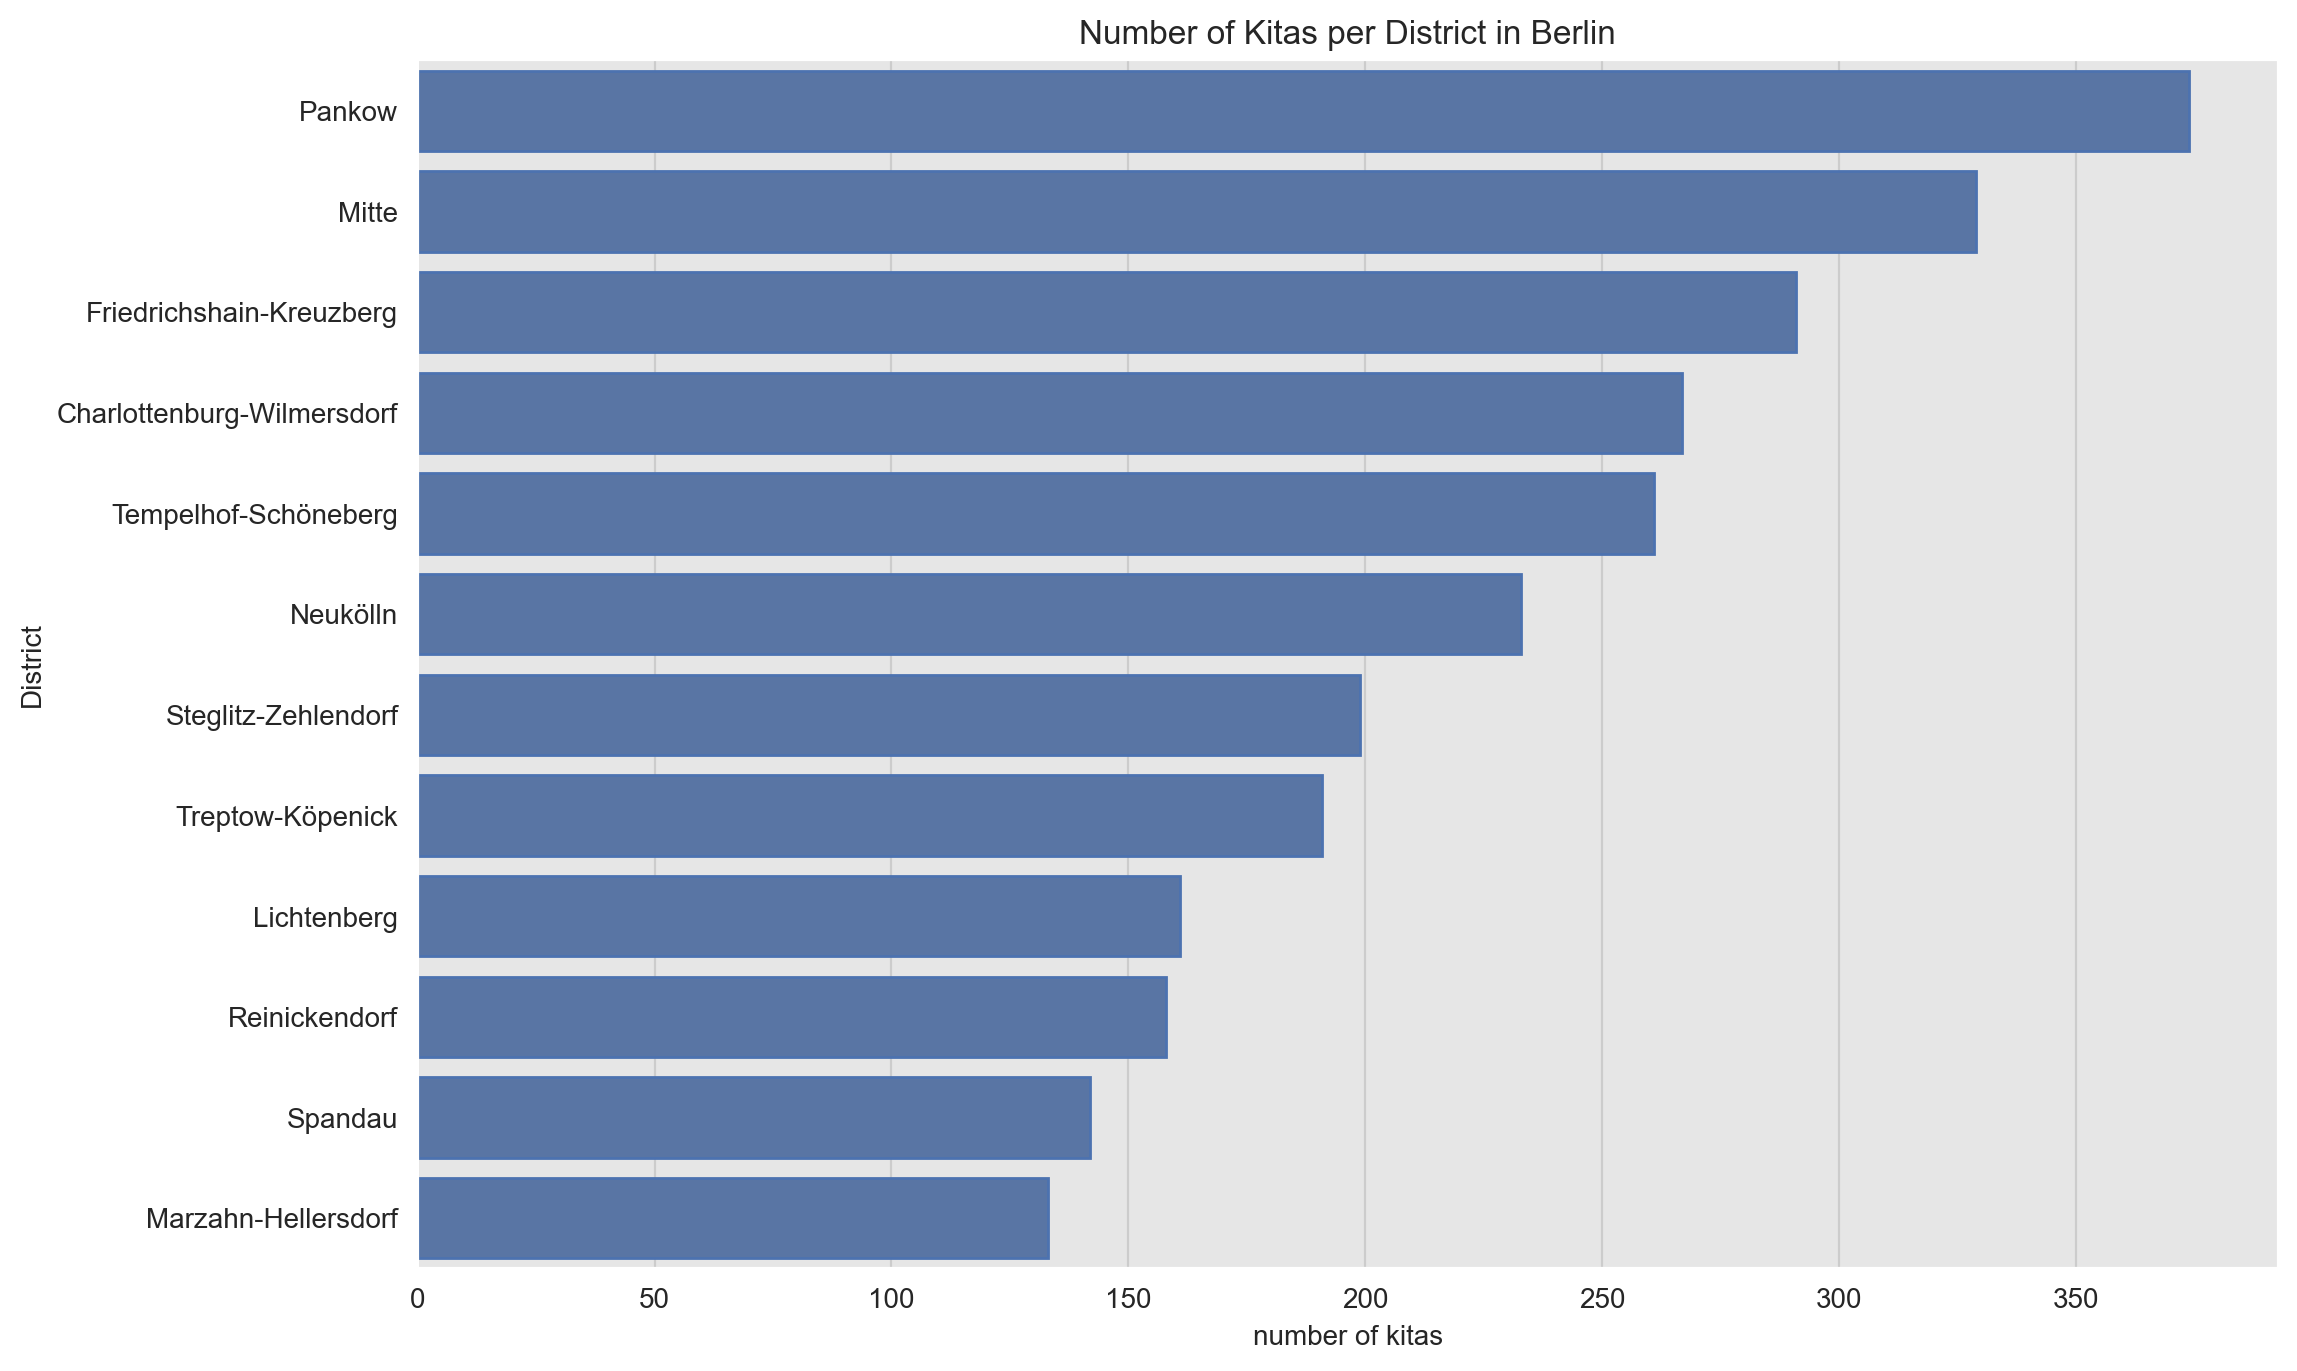

In [79]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['Betreuungsbezirk']) \
    .agg(n=('Einrichtungsname', 'count')) \
    .reset_index(drop=False) \
    .sort_values('n', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='n', 
        y='Betreuungsbezirk',
        color=sns_c[0],
        edgecolor=sns_c[0],
        ax=ax
    )
ax.set(
    title='Number of Kitas per District in Berlin', 
    xlabel='number of kitas', 
    ylabel='District'
);

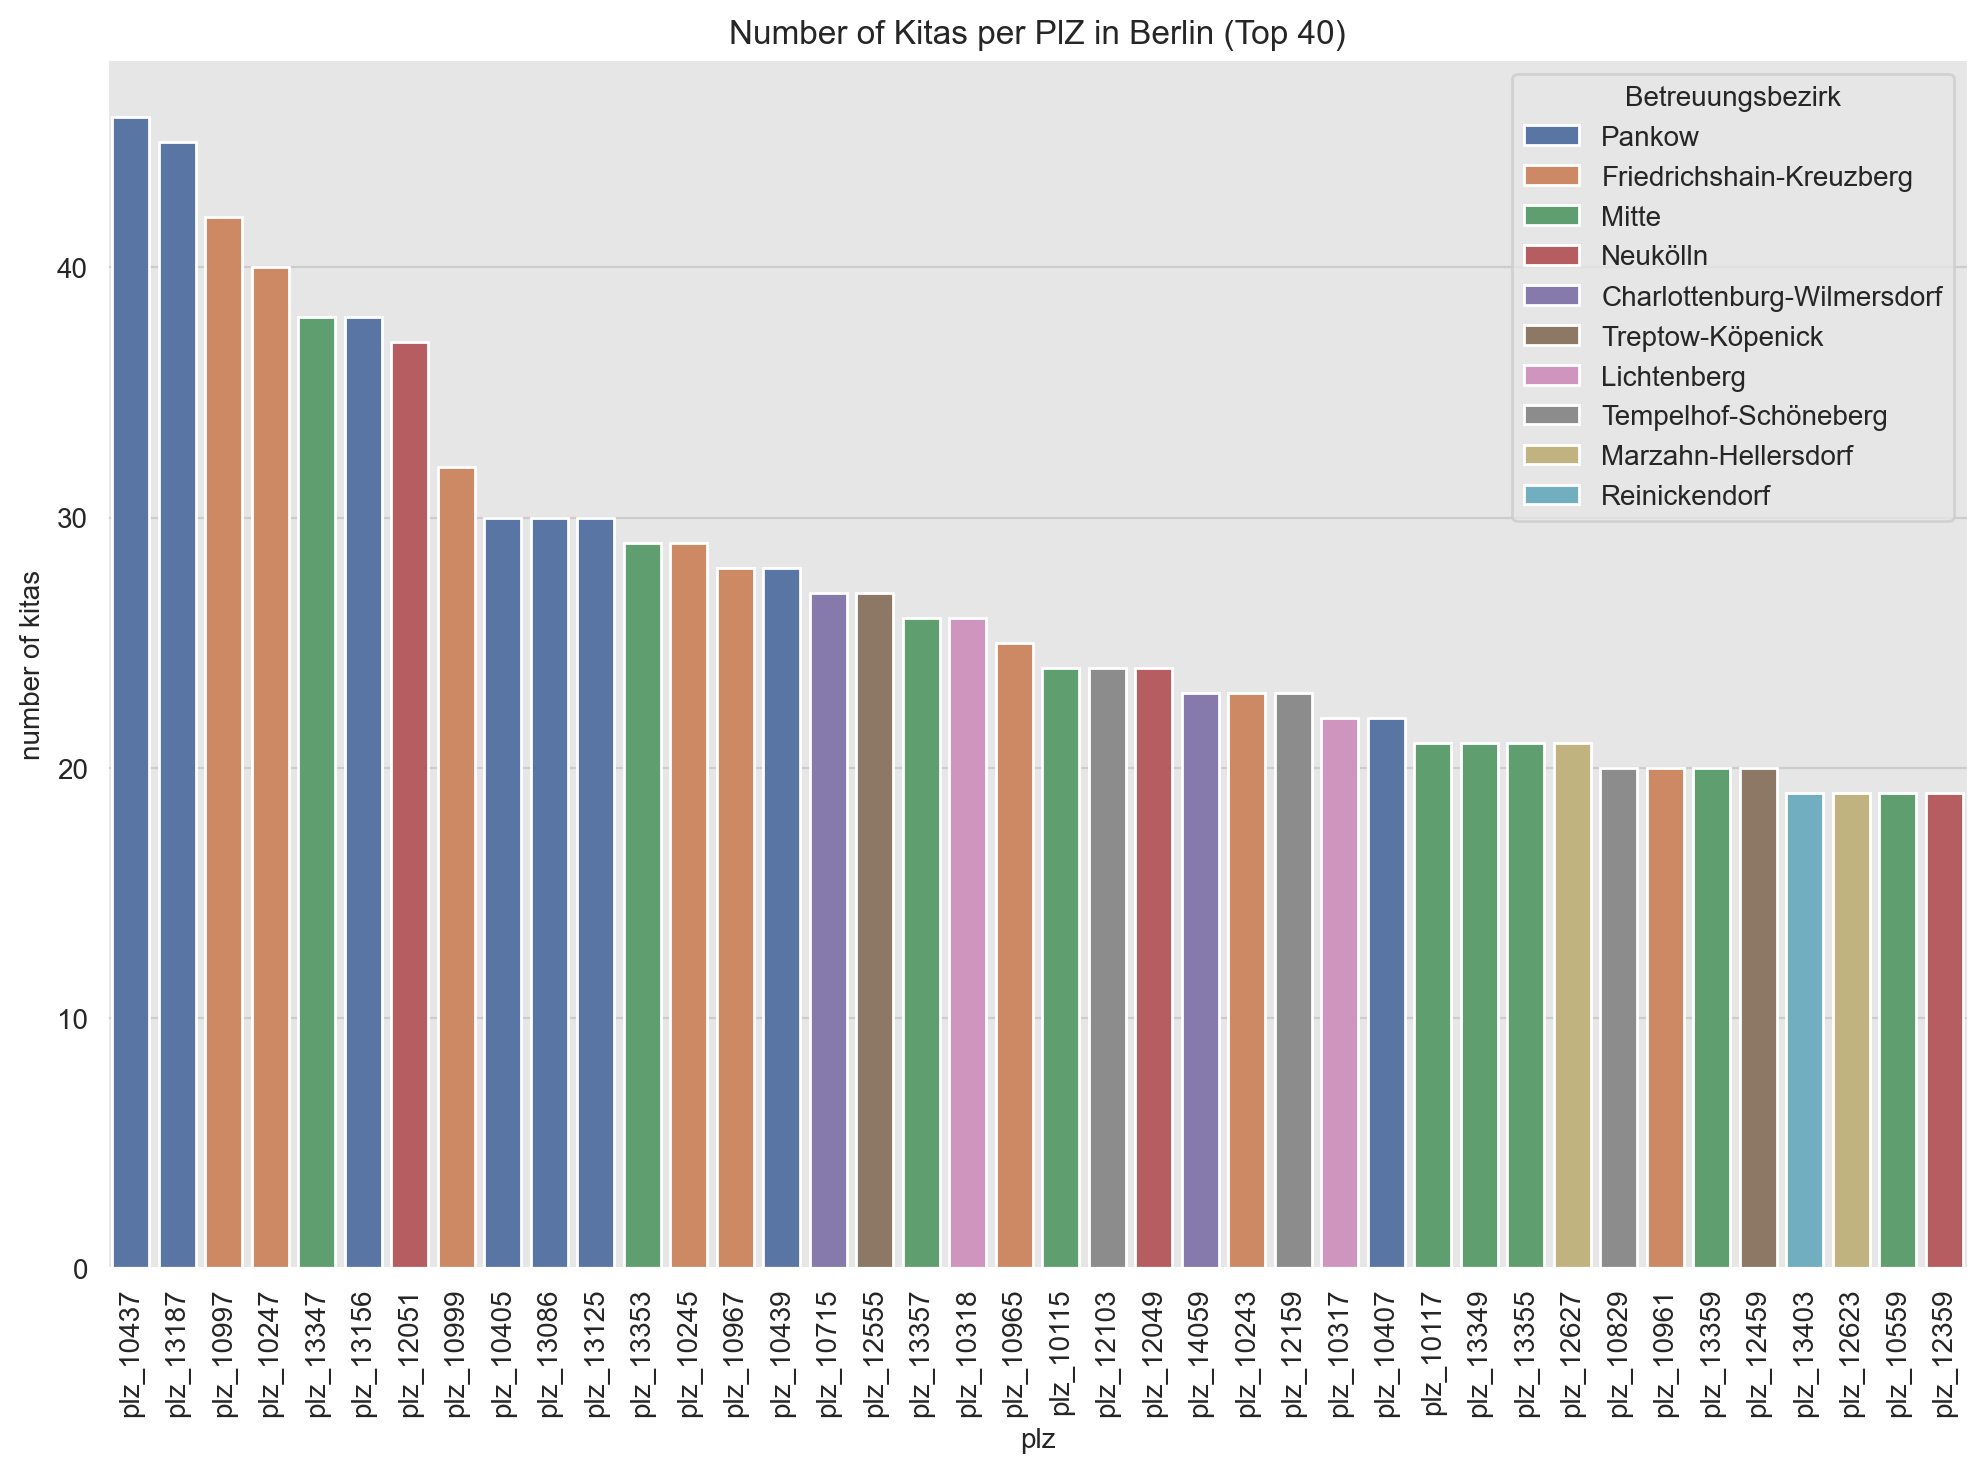

In [106]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['Betreuungsbezirk', 'PLZ']) \
    .agg(n=('Einrichtungsname', 'count')) \
    .reset_index(drop=False) \
    .assign(PLZ = lambda x: 'plz_' + x['PLZ'].astype(str)) \
    .sort_values('n', ascending=False) \
    .head(40) \
    .pipe((sns.barplot, 'data'),  
        x='PLZ',
        y='n',
        hue='Betreuungsbezirk',
        dodge=False,
        ax=ax
    )
ax.tick_params(axis='x', labelrotation=90)
ax.set(
    title='Number of Kitas per PlZ in Berlin (Top 40)', 
     xlabel='plz', 
     ylabel='number of kitas', 
);